In [2]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [3]:
#load the data
housing = pd.read_csv('../project_2/datasets/cleaned_train.csv')
test = pd.read_csv('../project_2/datasets/cleaned_test.csv')

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1963 entries, 0 to 1962
Data columns (total 49 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1963 non-null   int64  
 1   pid              1963 non-null   int64  
 2   ms_subclass      1963 non-null   int64  
 3   ms_zoning        1963 non-null   object 
 4   lot_area         1963 non-null   int64  
 5   lot_shape        1963 non-null   int64  
 6   lot_config       1963 non-null   object 
 7   neighborhood     1963 non-null   object 
 8   house_style      1963 non-null   object 
 9   overall_qual     1963 non-null   int64  
 10  overall_cond     1963 non-null   int64  
 11  year_built       1963 non-null   int64  
 12  year_remod/add   1963 non-null   int64  
 13  exterior_1st     1963 non-null   object 
 14  exterior_2nd     1963 non-null   object 
 15  mas_vnr_type     1963 non-null   object 
 16  mas_vnr_area     1963 non-null   float64
 17  exter_qual    

In [5]:
# group the numerical data

numerical_df = housing.select_dtypes(include=np.number)

#group categorical data
categorical_df = housing.select_dtypes(exclude=np.number)

In [6]:
numerical_df.columns

Index(['id', 'pid', 'ms_subclass', 'lot_area', 'lot_shape', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'exter_qual', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf',
       'total_bsmt_sf', 'heating_qc', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr',
       'kitchen_qual', 'totrms_abvgrd', 'fireplaces', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       '3ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'mo_sold',
       'yr_sold', 'saleprice'],
      dtype='object')

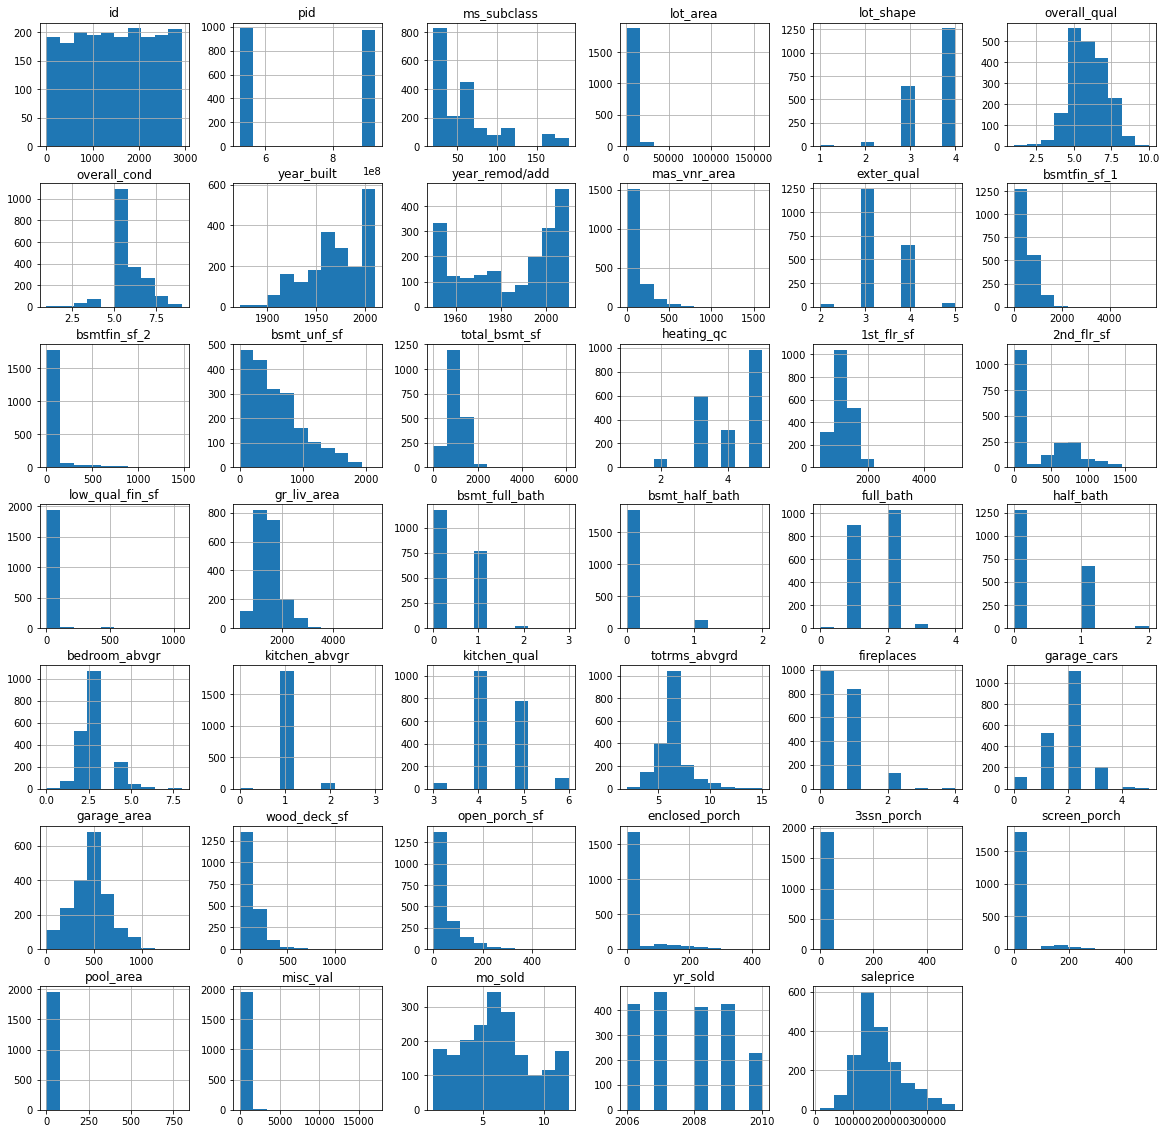

In [7]:
#plot hsitograms of all numerical columns to observe distribution
numerical_df.hist(figsize=(20, 20));

<b> action </b>: log the continuous features that are highly skewed. 

These features are: '2nd_flr_sf','lot_area', 'ms_subclass', 'screen_porch', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch', '3ssn_porch', 'screen_porch','bsmt_unf_sf'.

However before we log them, we do further exploration to identify patterns or anomalies. 

Further observations include, sale's price distribution being skewed to the right, we can log our target to make it more normally distributed. 

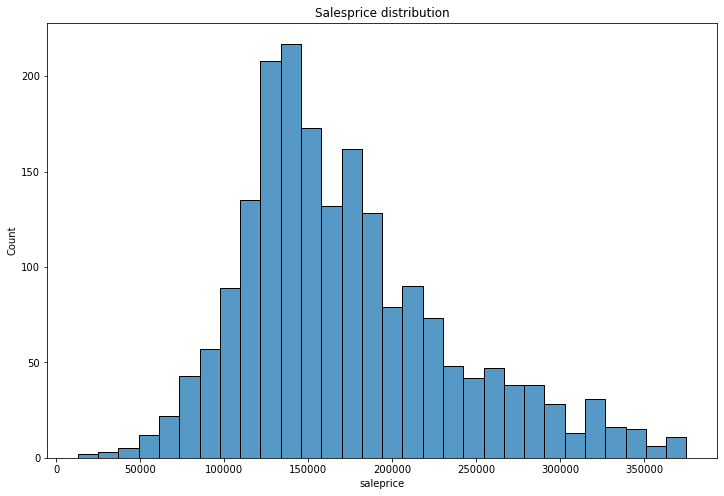

In [8]:
#further inspection of our future y-target
plt.figure(figsize=(12,8))
sns.histplot(data = housing.saleprice);
plt.title('Salesprice distribution');

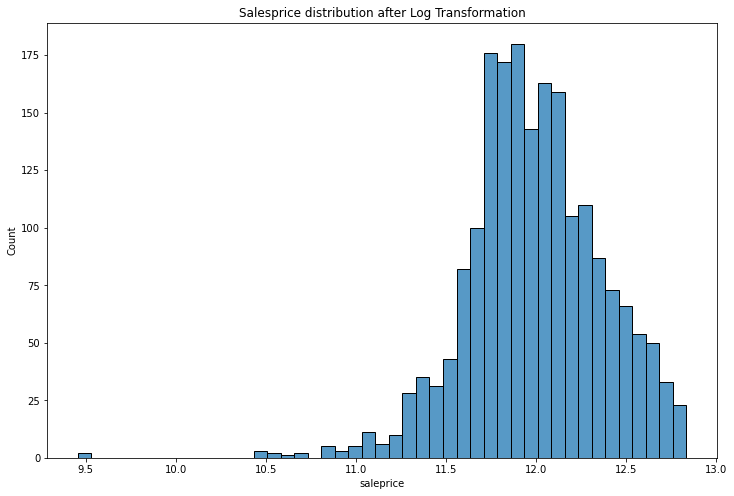

In [9]:
plt.figure(figsize=(12,8))
sns.histplot(data = np.log(housing.saleprice));
plt.title('Salesprice distribution after Log Transformation');

In [10]:
#transform future y_target
housing.saleprice = np.log(housing.saleprice);

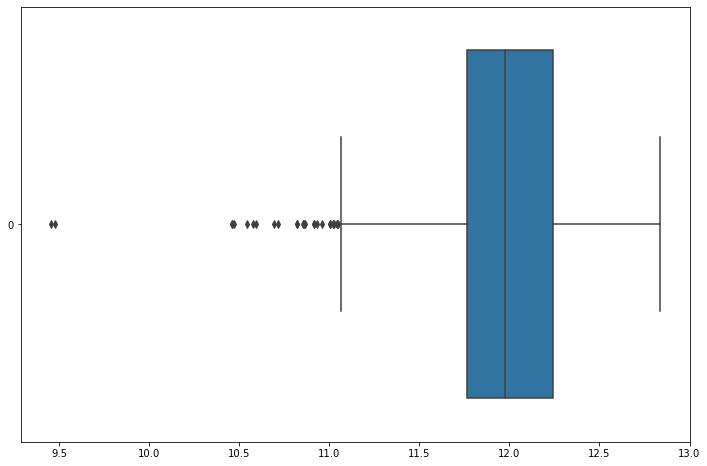

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(data = housing.saleprice, orient = 'h');

<b>observation</b>: two outlier exist which would affect our model, we should therefore drop these data points. 

In [12]:
row_to_drop = list(housing[housing.saleprice <10].index)

In [13]:
housing.drop(row_to_drop,axis=0,inplace=True) 

<b>observation</b>: The Salesprice distribution is now more normally distributed. The target variable shall remain transformed. 

In [14]:
#comparing skewed data to our target 
to_log = ['screen_porch', 'bsmtfin_sf_1', 'bsmtfin_sf_2', 'wood_deck_sf', 'open_porch_sf','saleprice','enclosed_porch', '3ssn_porch', 'screen_porch','2nd_flr_sf','lot_area', 'ms_subclass','gr_liv_area','bsmt_unf_sf']

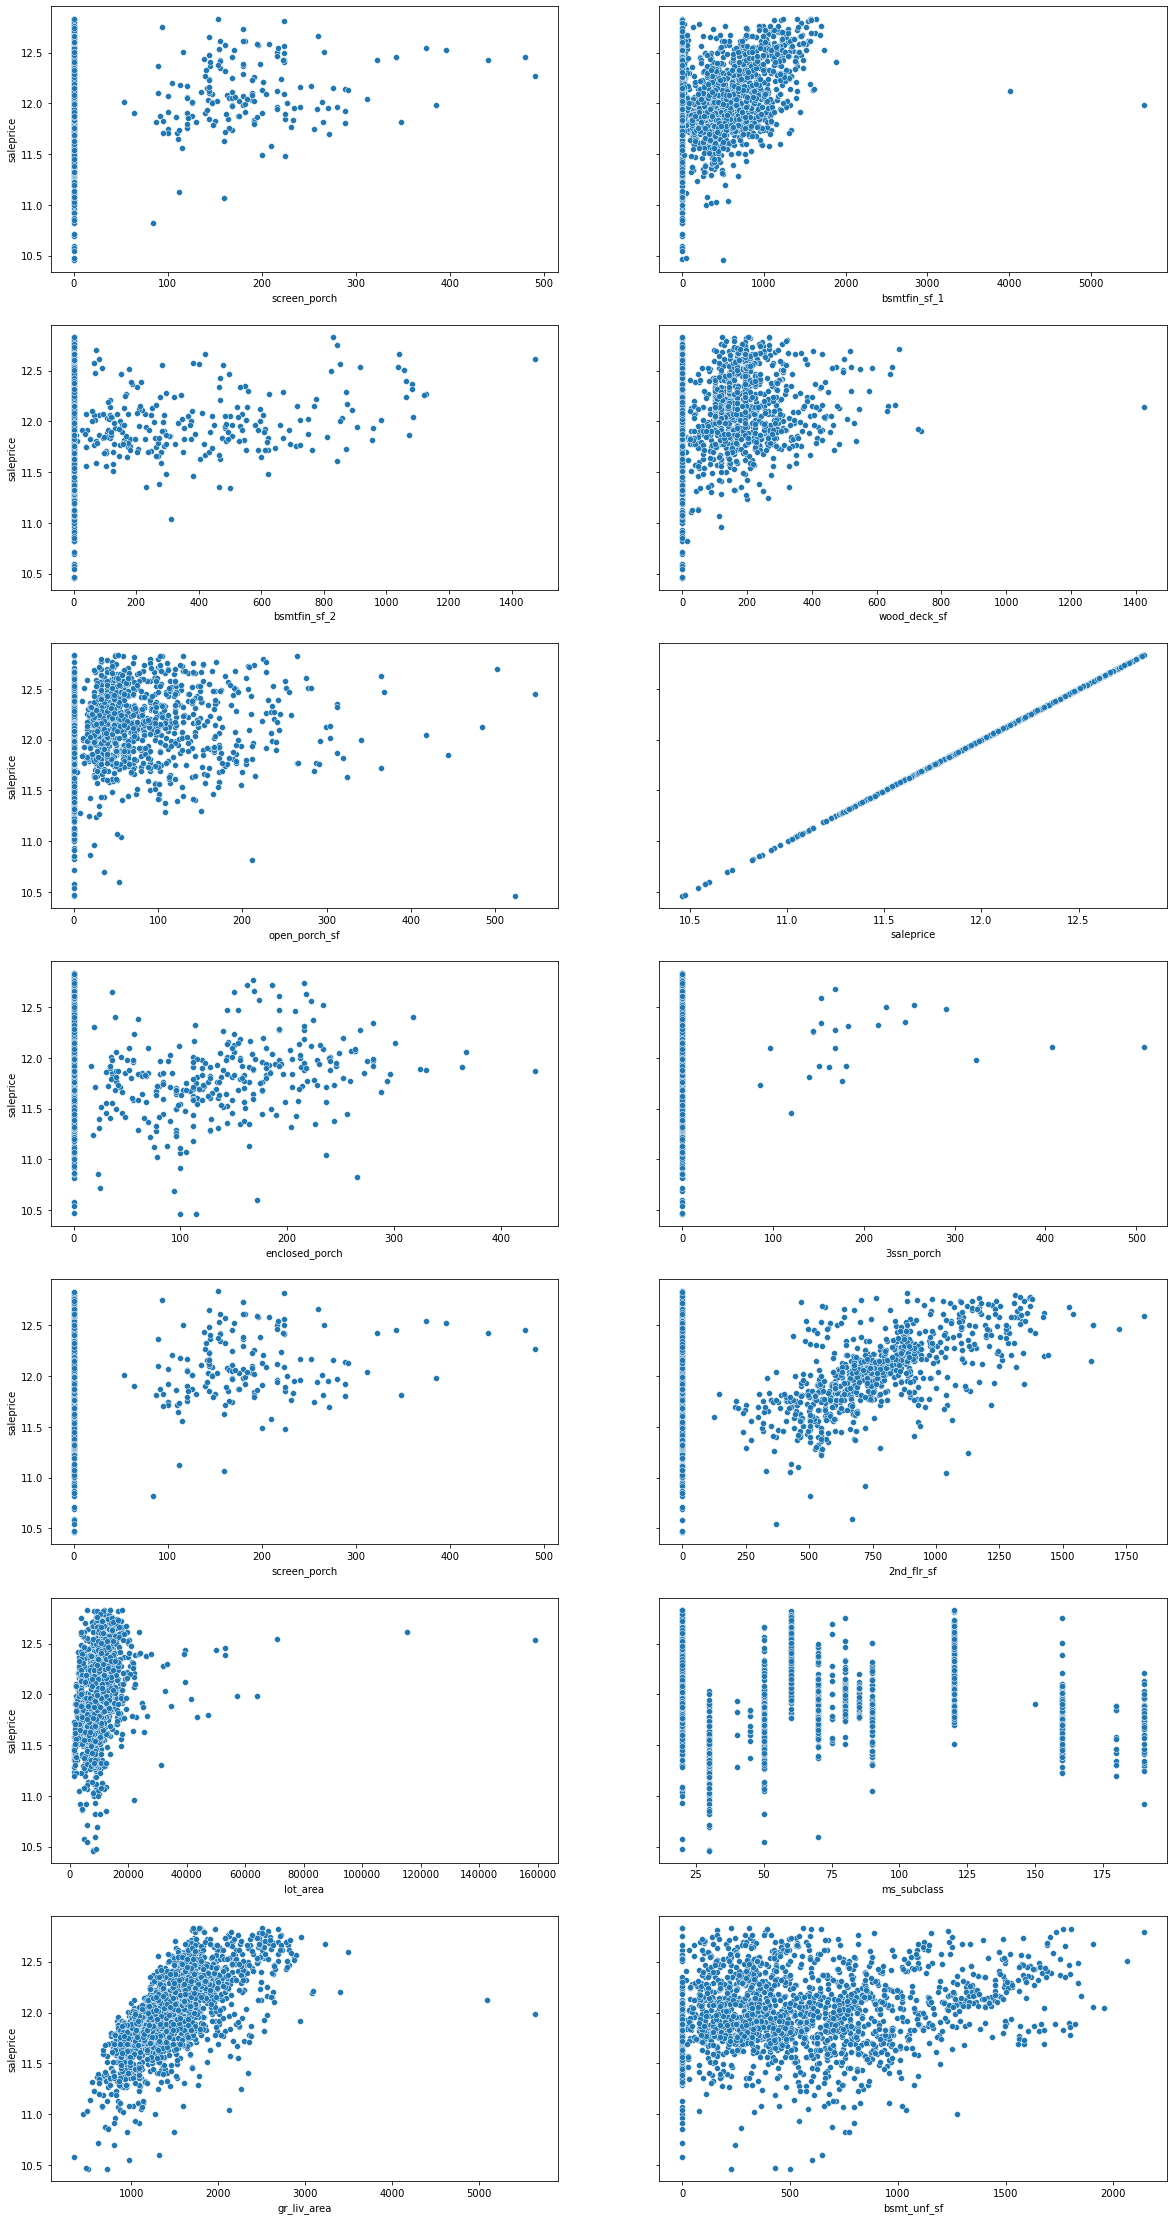

In [15]:
fig, ax = plt.subplots(nrows=7, ncols=2, figsize=(20,40), sharey=True)

ax = ax.flatten()

for idx, col in enumerate(housing[to_log].columns):
    sns.scatterplot(data = housing , x = col, y ='saleprice', ax = ax[idx])
    

<b>observation</b>: We cannot log most features above as majority features have value of zero which would result to 'undefined' if we were to log. We can only log 'lot_area'.

However, for the feature '3ssn_porch' a small percentage of data is outside the mode value, and therefore we can drop this feature. Aditionally, we can drop features that are mostly mode values.

In [16]:
#features that have with high percentage of mode data, condition > 80%

unnecessary_col = []

for col in housing[to_log].columns:
    #calculate percentage of most frequent category
    pct = housing[col].value_counts().iloc[0]/len(housing[col])
    if pct > 0.80:
        unnecessary_col.append(col)
        print(f'{col} : {pct}')
        print('\n')

screen_porch : 0.9148393676695563


bsmtfin_sf_2 : 0.8765935747067822


enclosed_porch : 0.8373278939316675


3ssn_porch : 0.9877613462519123


screen_porch : 0.9148393676695563




In [17]:
#drop unnecessary columns from both datasets
housing.drop(columns=unnecessary_col,inplace=True)
test.drop(columns=unnecessary_col,inplace=True)

In [18]:
#log'lot_area' feature for both data sets

housing['lot_area'] = housing.lot_area.apply(lambda x: np.log(x))
housing['gr_liv_area'] = housing.lot_area.apply(lambda x: np.log(x))
test['lot_area'] = test.lot_area.apply(lambda x: np.log(x))
test['gr_liv_area'] = test.lot_area.apply(lambda x: np.log(x))

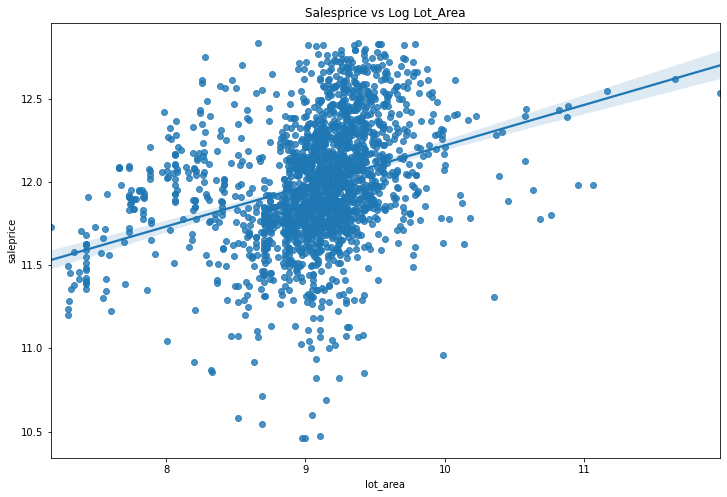

In [19]:
plt.figure(figsize=(12,8))
sns.regplot(x = housing.lot_area, y=housing.saleprice);
plt.title('Salesprice vs Log Lot_Area');

<b>observation</b>: Data distribution after log is less skewed however those not appear to have a strong linear relationship with saleprice, irregardless, the transformation of this feature willremain.

In [19]:
# regroup the numerical data

numerical_df = housing.select_dtypes(include=np.number)

#group categorical data
categorical_df = housing.select_dtypes(exclude=np.number)

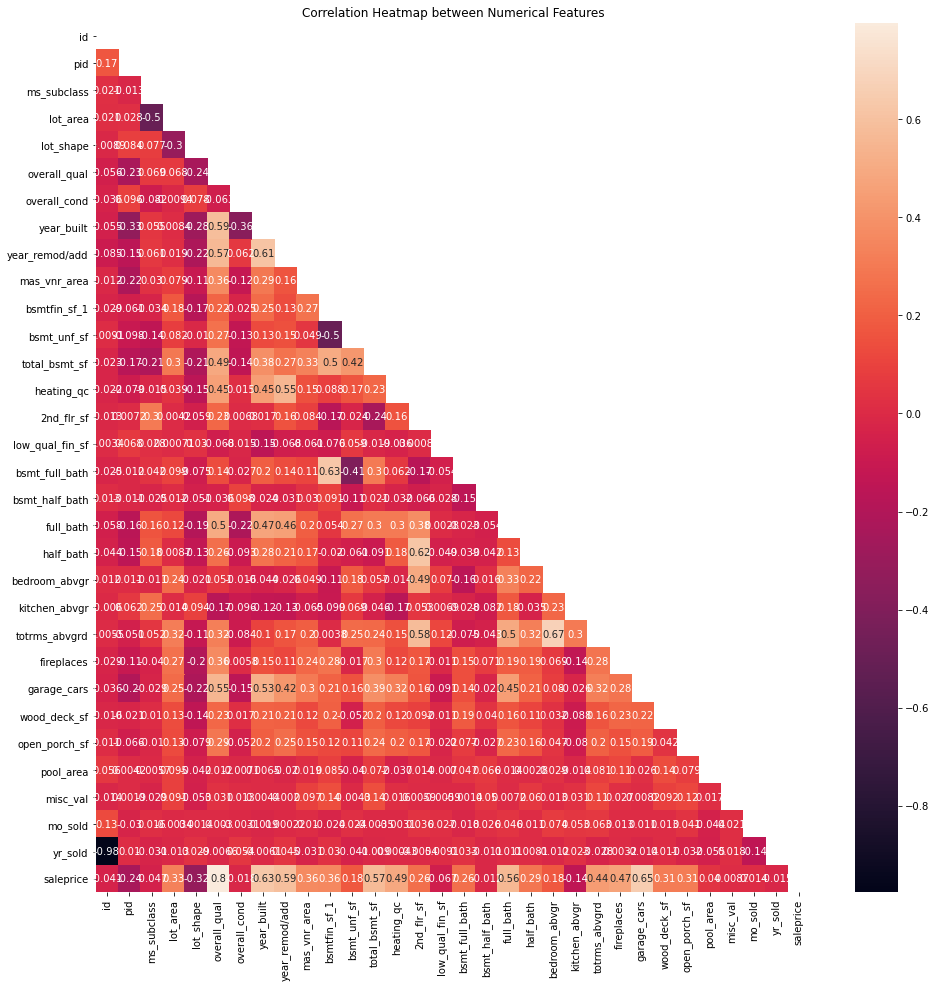

In [33]:
plt.figure(figsize=(16,16))

mask_ut=np.triu(np.ones(numerical_df.corr().shape)).astype(np.bool)

sns.heatmap(numerical_df.corr(),mask=mask_ut, annot=True)

plt.title('Correlation Heatmap between Numerical Features');

plt.savefig(fname='../project_2/images/feature_corr_heatmap.png');

<b>observation</b>: we can see that there are some features that are correlated, however from the visualization, it is rather hard to identify them. We will therefore write a codeblock instead.



In [21]:
#check for data with correlation 

corr_matrix = housing.iloc[:,:44].corr().abs()
high_corr_var=np.where(corr_matrix>0.7)
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('id', 'yr_sold'),
 ('lot_area', 'gr_liv_area'),
 ('overall_qual', 'exter_qual'),
 ('exter_qual', 'kitchen_qual'),
 ('total_bsmt_sf', '1st_flr_sf'),
 ('garage_cars', 'garage_area')]

<b>observation</b>: other than 'id' and 'yr_sold', we can see that the other correlated pairs of features are related as they provide the same information.  We shall drop one feature from each pair.

In [22]:
#drop only one feature per each correlated pair

col_to_drop = [y for x,y in high_corr_var[1:]]
housing.drop(columns=col_to_drop,inplace=True)
test.drop(columns=col_to_drop,inplace=True)

In [23]:
# regroup the numerical data

numerical_df = housing.select_dtypes(include=np.number)

#group categorical data
categorical_df = housing.select_dtypes(exclude=np.number)

In [24]:
numerical_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1961 entries, 0 to 1962
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               1961 non-null   int64  
 1   pid              1961 non-null   int64  
 2   ms_subclass      1961 non-null   int64  
 3   lot_area         1961 non-null   float64
 4   lot_shape        1961 non-null   int64  
 5   overall_qual     1961 non-null   int64  
 6   overall_cond     1961 non-null   int64  
 7   year_built       1961 non-null   int64  
 8   year_remod/add   1961 non-null   int64  
 9   mas_vnr_area     1961 non-null   float64
 10  bsmtfin_sf_1     1961 non-null   float64
 11  bsmt_unf_sf      1961 non-null   float64
 12  total_bsmt_sf    1961 non-null   float64
 13  heating_qc       1961 non-null   int64  
 14  2nd_flr_sf       1961 non-null   int64  
 15  low_qual_fin_sf  1961 non-null   int64  
 16  bsmt_full_bath   1961 non-null   float64
 17  bsmt_half_bath

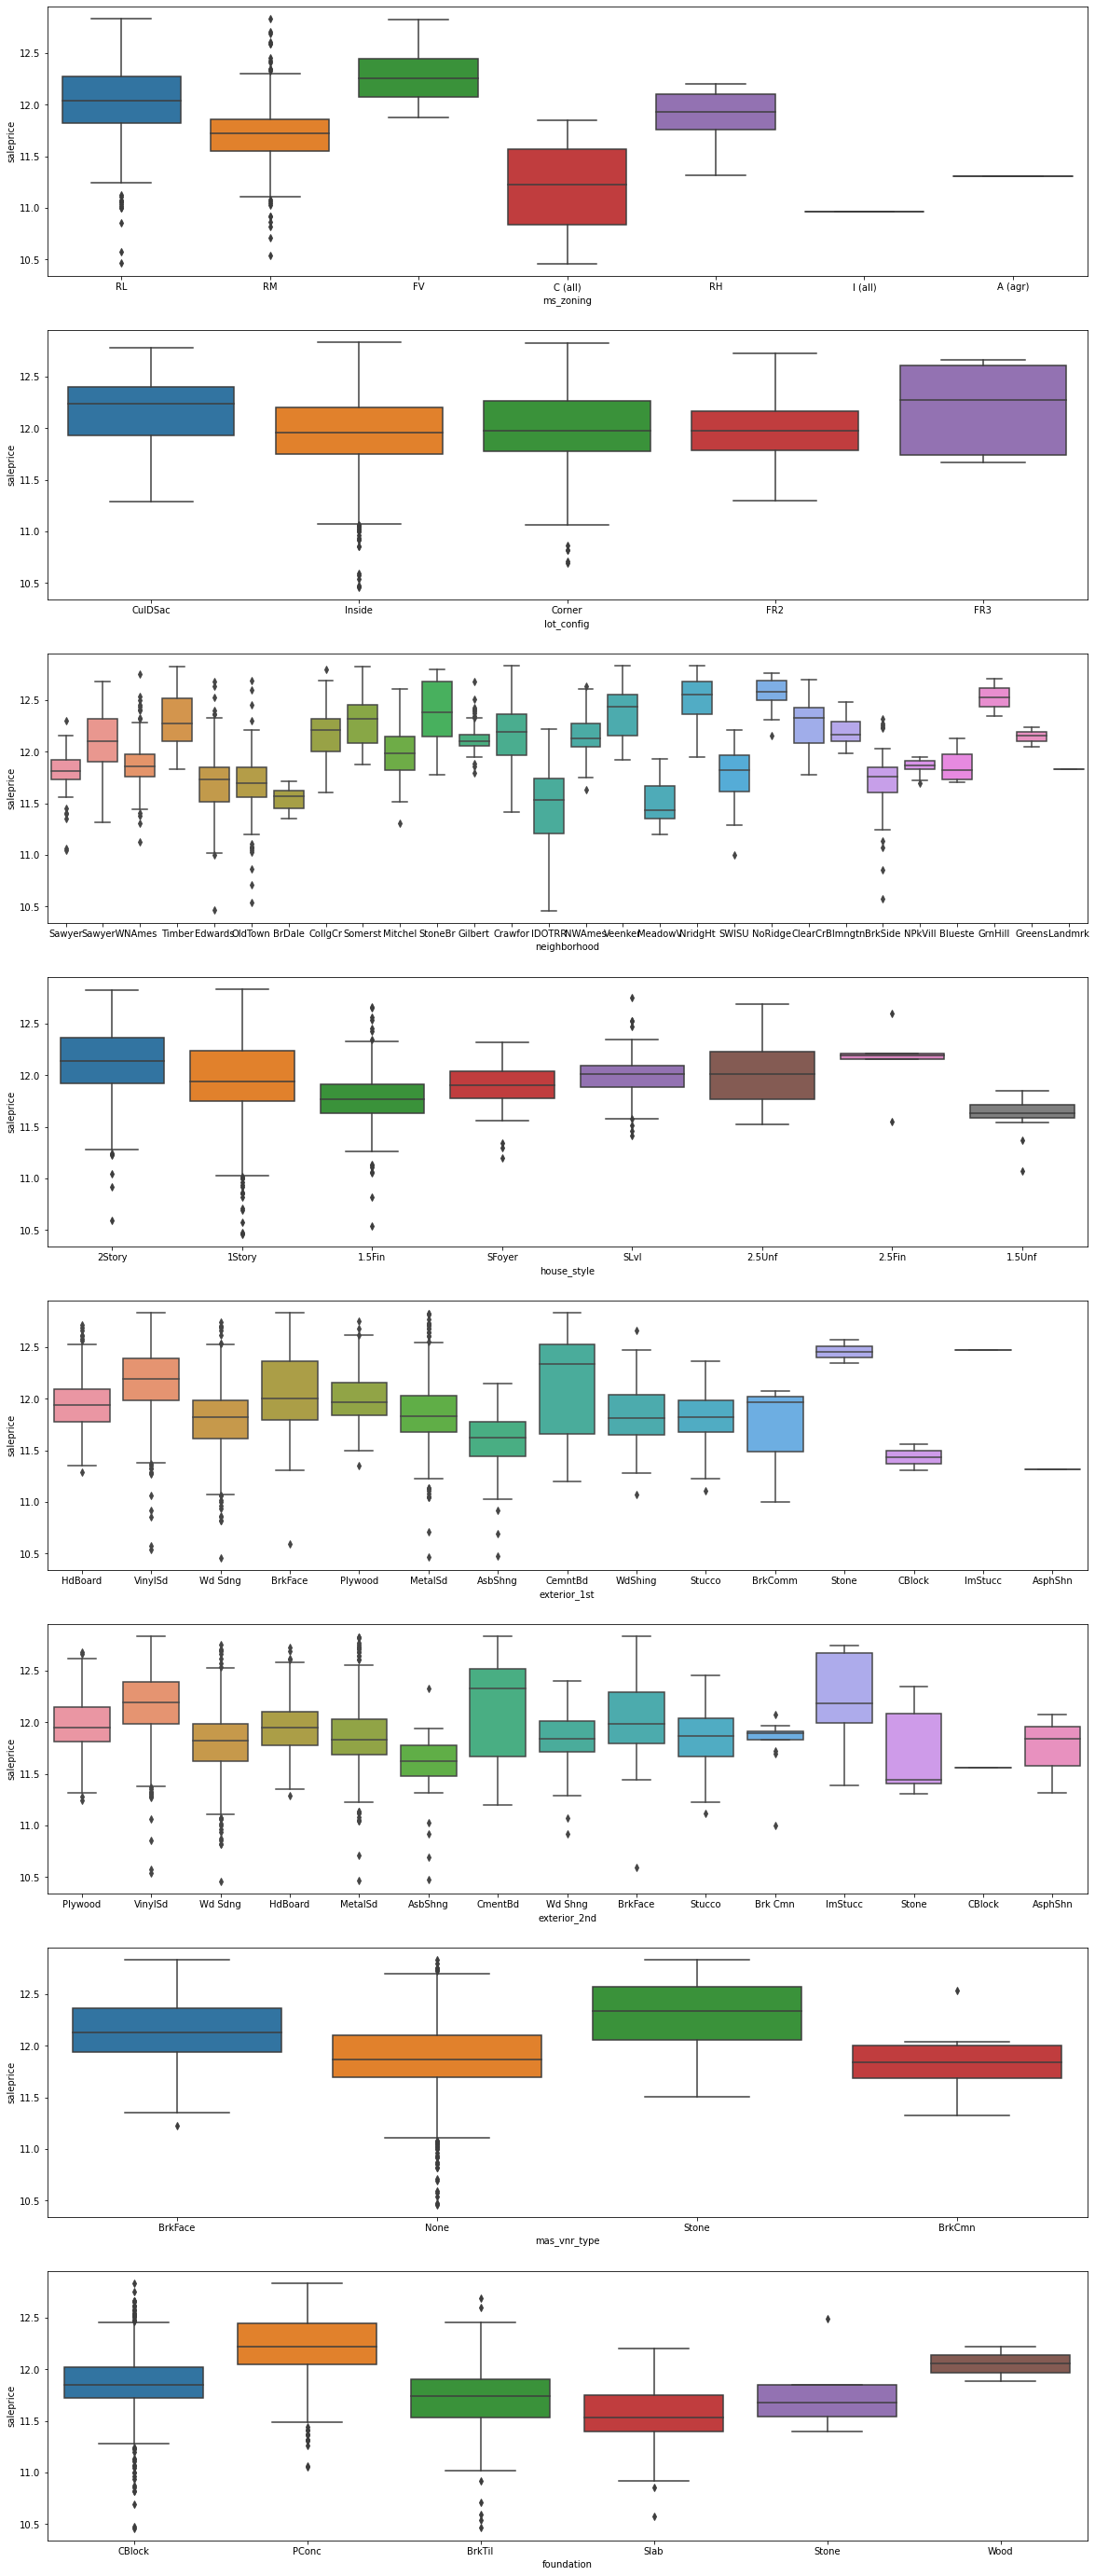

In [25]:
fig, ax = plt.subplots(nrows=8, ncols=1, figsize=(20,50), sharey=True)

ax = ax.flatten()

for idx, col in enumerate(categorical_df.columns):
    sns.boxplot(data = categorical_df, x = col, y =housing['saleprice'], ax = ax[idx])

<b>observation</b>: 'exterior_1' and 'exterior_2nd' have very similar distributions. Either one should be dropped. 

In [26]:
#drop the exterior_2 column from both datasets
housing.drop(columns=['exterior_2nd'],inplace=True)
test.drop(columns=['exterior_2nd'],inplace=True)

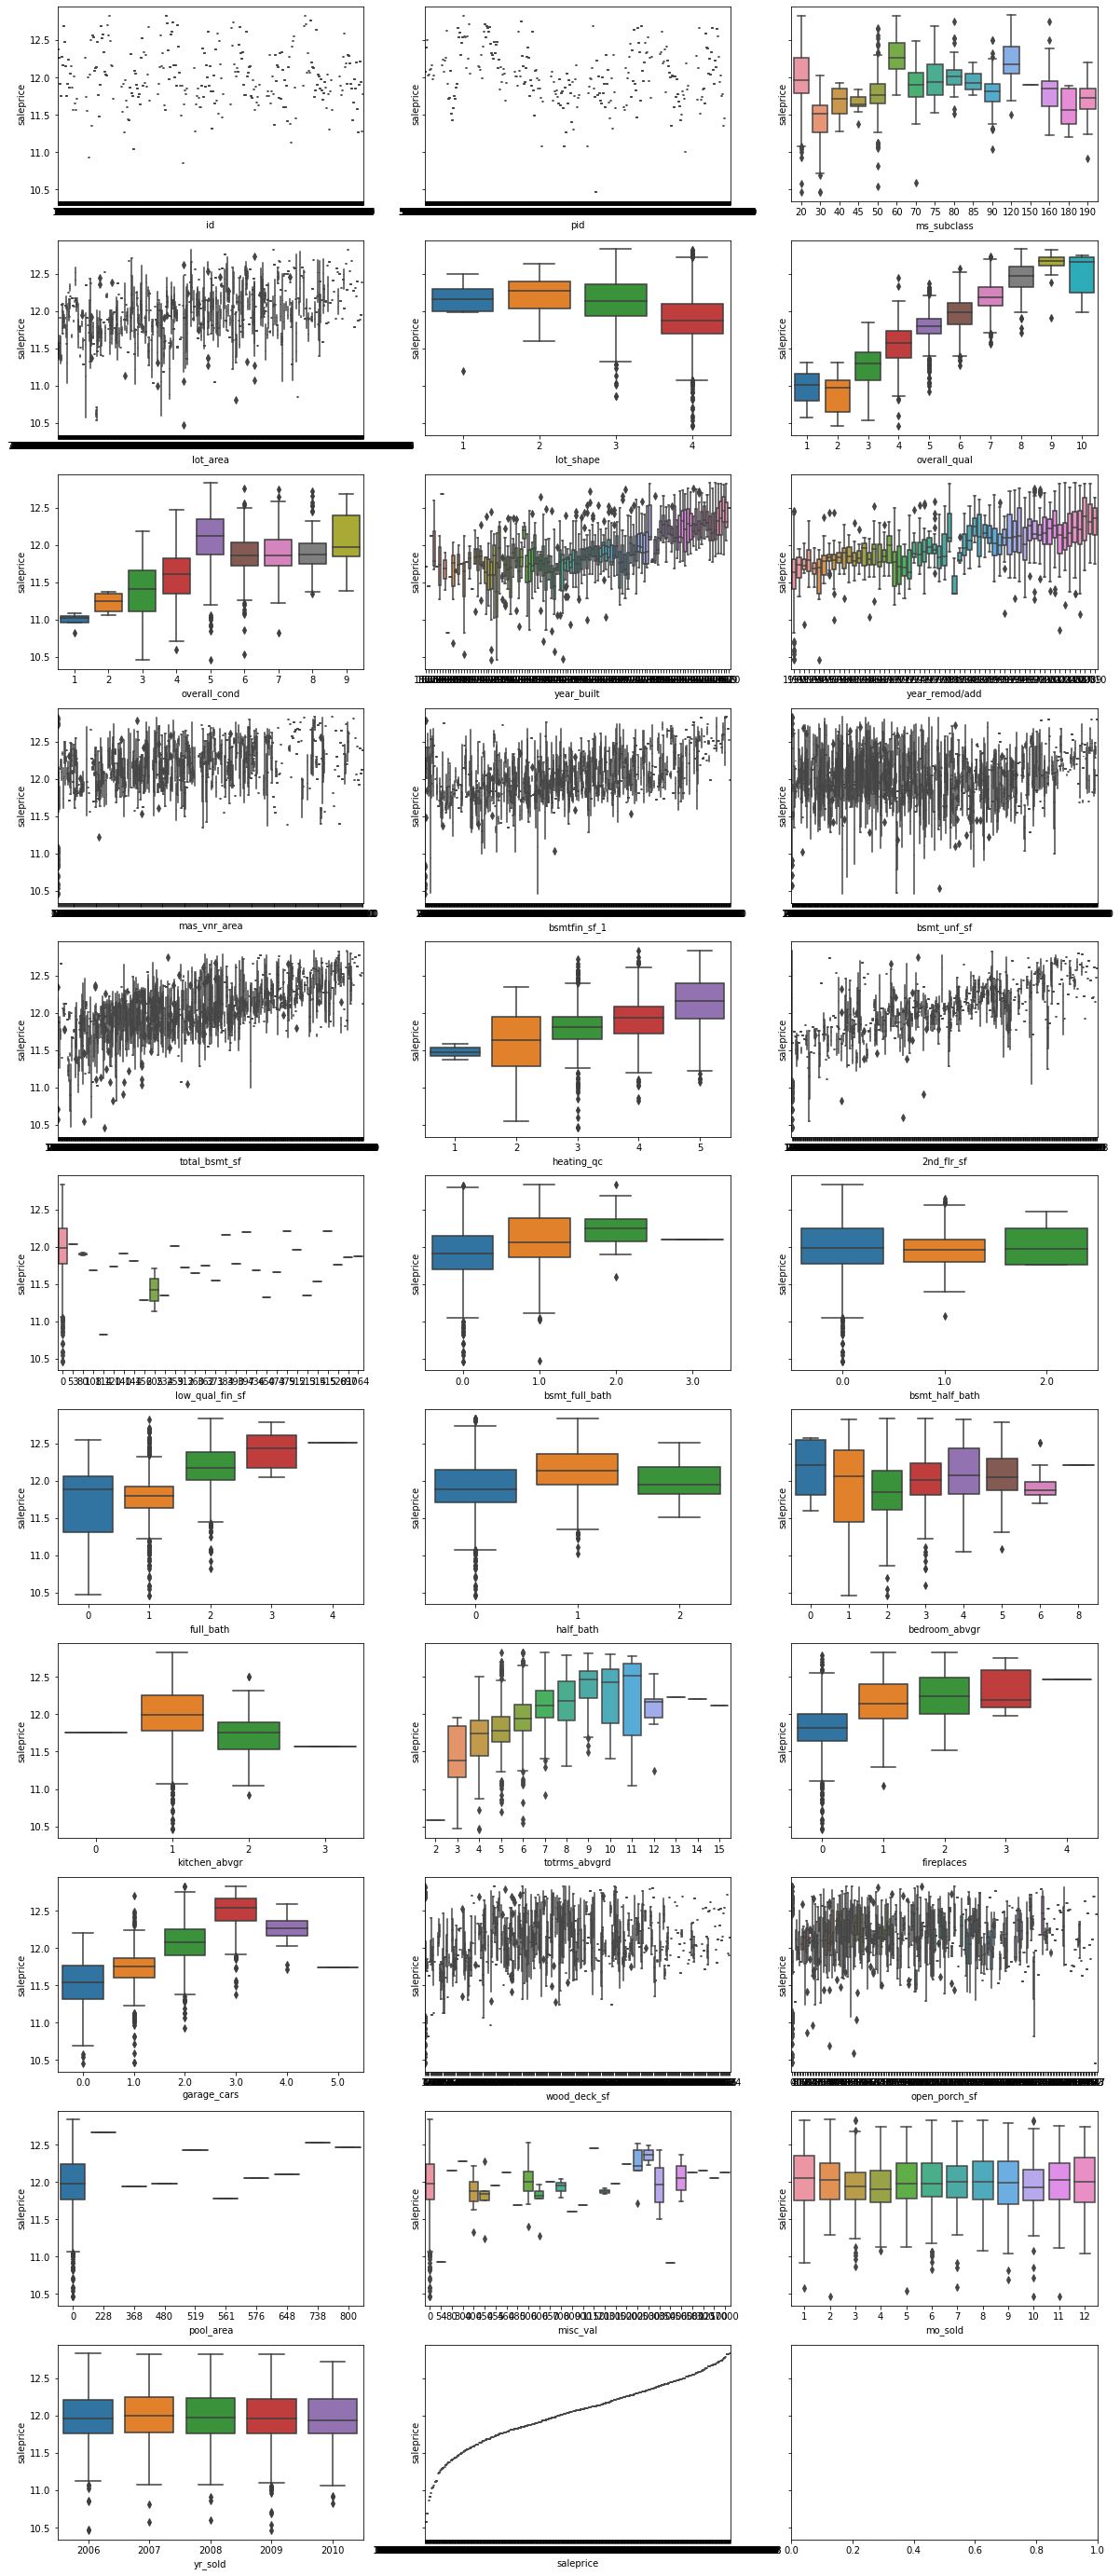

In [27]:
fig, ax = plt.subplots(nrows=11, ncols=3, figsize=(20,50), sharey=True)

ax = ax.flatten()

for idx, col in enumerate(numerical_df.columns):
    sns.boxplot(data = numerical_df , x = col, y =housing['saleprice'], ax = ax[idx])

<b>observation</b>: anomolies observed are 'pool_area','misc_val' and 'low_qual_fin_sf'

In [28]:
#drop the 2 columns with anomolies from both datasets
housing.drop(columns=['pool_area','low_qual_fin_sf','misc_val'],inplace=True)
test.drop(columns=['pool_area','low_qual_fin_sf','misc_val'],inplace=True)

In [34]:
categorical_df.head()

,ms_zoning,lot_config,neighborhood,house_style,exterior_1st,exterior_2nd,mas_vnr_type,foundation
0,RL,CulDSac,Sawyer,2Story,HdBoard,Plywood,BrkFace,CBlock
1,RL,CulDSac,SawyerW,2Story,VinylSd,VinylSd,BrkFace,PConc
2,RL,Inside,NAmes,1Story,VinylSd,VinylSd,None,CBlock
3,RL,Inside,Timber,2Story,VinylSd,VinylSd,None,PConc
4,RL,Inside,SawyerW,1.5Fin,Wd Sdng,Plywood,None,PConc


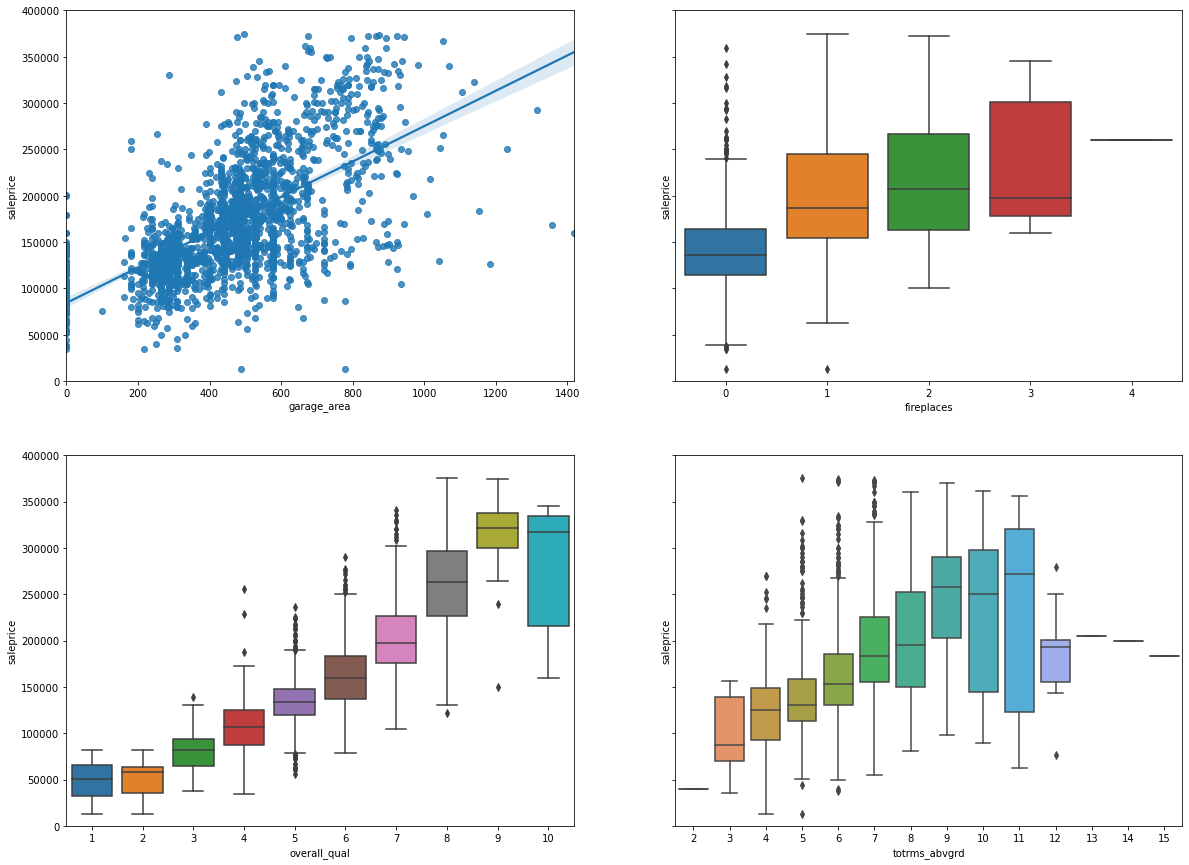

In [109]:
extra_graph = housing[['garage_area','fireplaces','overall_qual', 'totrms_abvgrd']]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,15), sharey=True, )

ax = ax.flatten()


for idx, col in enumerate(extra_graph.columns):

    if extra_graph[col].dtypes == np.float:
        sns.regplot(data = extra_graph, x = col, y =housing['saleprice'], ax = ax[idx])
    else:
        sns.boxplot(data = extra_graph, x = col, y =housing['saleprice'], ax = ax[idx]);
    
    
plt.ylim(0,400000)

plt.savefig(fname='../project_2/images/extra_bp.png')

In [79]:
extra_graph['total_sf']

0       2204.0
1       3035.0
2       2114.0
3       1828.0
4       2121.0
         ...  
1958    3612.0
1959    1722.0
1960    2809.0
1961    2400.0
1962    2798.0
Name: total_sf, Length: 1963, dtype: float64

In [29]:
#export dfs

housing.to_csv('/Users/AdelAlsagoff/DSI/materials copy/project_2/datasets/final_train.csv', index = False)

test.to_csv('/Users/AdelAlsagoff/DSI/materials copy/project_2/datasets/final_test.csv', index = False)

